# **รายชื่อสมาชิก**
#64102010070  นายกฤษติณ ปานทอง
#64102010287  นายชญานิน บุตะเขียว
#64102010300  นายวุฒิชัย ภูบุญทอง
#64102010493  นายจารุภัทร ตรีธนูชัย
#64102010495   นางสาวพิมพ์ศจี พบหิรัญโสภณ

# **IMPORT LIBRARY**

In [ ]:
import pandas as pd
import statsmodels.api as sm
import string
from sklearn.preprocessing import StandardScaler
import itertools
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction import text
from textwrap import wrap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')


from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **EDA and Preprocessing**

**Encoding and Preprocessimg**

---



In [ ]:
# Read the CSV file
df = pd.read_csv('/content/netflixData.csv')  # Replace with your actual file path
print(df.isnull().sum())

Show Id                  0
Title                    0
Description              0
Director              2064
Genres                   0
Cast                   530
Production Country     559
Release Date             3
Rating                   4
Duration                 3
Imdb Score             608
Content Type             0
Date Added            1335
dtype: int64


 - ทำการแก้ไข ค่าของ IMDB Score ที่เป็น 0.0/10 ให้กลายเป็น ตัว 0.0 เพียงอย่างเดียวแล้วแปลงเป็น float
 - เหนื่องจาก Duration เป็นการกำหนดระยะเวลาของ Season และ Min เราจึงแยกเป็น Seires และ Movies ตามลำดับ
 - แทนค่าของ row ที่วางเป็นค่าที่มี ffrequency สูงสำหรับค่าทที่เป็น integer และ ใช้ค่าเฉลี่ยแทนตัว Feature

In [ ]:
# Clean IMDb Score column and convert to integers
df['Imdb Score'] = df['Imdb Score'].str.replace('/10', '').astype(float)
df = df.dropna(subset=['Imdb Score'])

# Extract numerical values and units
df[['Duration_Num', 'Duration_Unit']] = df['Duration'].str.extract('(\d+) (\w+)', expand=True)

# Convert 'Duration_Num' to numeric (some values might be strings)
df['Duration_Num'] = pd.to_numeric(df['Duration_Num'], errors='coerce')


num_col = df._get_numeric_data().columns.tolist()
cat_col = set(df.columns) - set(num_col)
for i in cat_col:
    df[i].fillna(df[i].mode()[0], inplace=True)
for i in num_col:
    df[i].fillna(df[i].mean(), inplace=True)

# Now 'Imdb Score' column contains integers
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5359 entries, 0 to 5966
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Show Id             5359 non-null   object 
 1   Title               5359 non-null   object 
 2   Description         5359 non-null   object 
 3   Director            5359 non-null   object 
 4   Genres              5359 non-null   object 
 5   Cast                5359 non-null   object 
 6   Production Country  5359 non-null   object 
 7   Release Date        5359 non-null   float64
 8   Rating              5359 non-null   object 
 9   Duration            5359 non-null   object 
 10  Imdb Score          5359 non-null   float64
 11  Content Type        5359 non-null   object 
 12  Date Added          5359 non-null   object 
 13  Duration_Num        5359 non-null   int64  
 14  Duration_Unit       5359 non-null   object 
dtypes: float64(2), int64(1), object(12)
memory usage: 669.9

,Show Id,Title,Description,Director,Genres,Cast,Production Country,Release Date,Rating,Duration,Imdb Score,Content Type,Date Added,Duration_Num,Duration_Unit
0,cc1b6ed9-cf9e-4057-8303-34577fb54477,(Un)Well,This docuseries takes a deep dive into the luc...,"Raúl Campos, Jan Suter",Reality TV,Jeff Dunham,United States,2020.0,TV-MA,1 Season,6.6,TV Show,"June 2, 2021",1,Season
1,e2ef4e91-fb25-42ab-b485-be8e3b23dedb,#Alive,"As a grisly virus rampages a city, a lone man ...",Cho Il,"Horror Movies, International Movies, Thrillers","Yoo Ah-in, Park Shin-hye",South Korea,2020.0,TV-MA,99 min,6.2,Movie,"September 8, 2020",99,min
2,b01b73b7-81f6-47a7-86d8-acb63080d525,#AnneFrank - Parallel Stories,"Through her diary, Anne Frank's story is retol...","Sabina Fedeli, Anna Migotto","Documentaries, International Movies","Helen Mirren, Gengher Gatti",Italy,2019.0,TV-14,95 min,6.4,Movie,"July 1, 2020",95,min
3,b6611af0-f53c-4a08-9ffa-9716dc57eb9c,#blackAF,Kenya Barris and his family navigate relations...,"Raúl Campos, Jan Suter",TV Comedies,"Kenya Barris, Rashida Jones, Iman Benson, Genn...",United States,2020.0,TV-MA,1 Season,6.6,TV Show,"June 2, 2021",1,Season
4,7f2d4170-bab8-4d75-adc2-197f7124c070,#cats_the_mewvie,This pawesome documentary explores how our fel...,Michael Margolis,"Documentaries, International Movies",Jeff Dunham,Canada,2020.0,TV-14,90 min,5.1,Movie,"February 5, 2020",90,min


**EDA**

---



In [ ]:
sample = df.sample(n=100)

Text(0, 0.5, 'number of production')

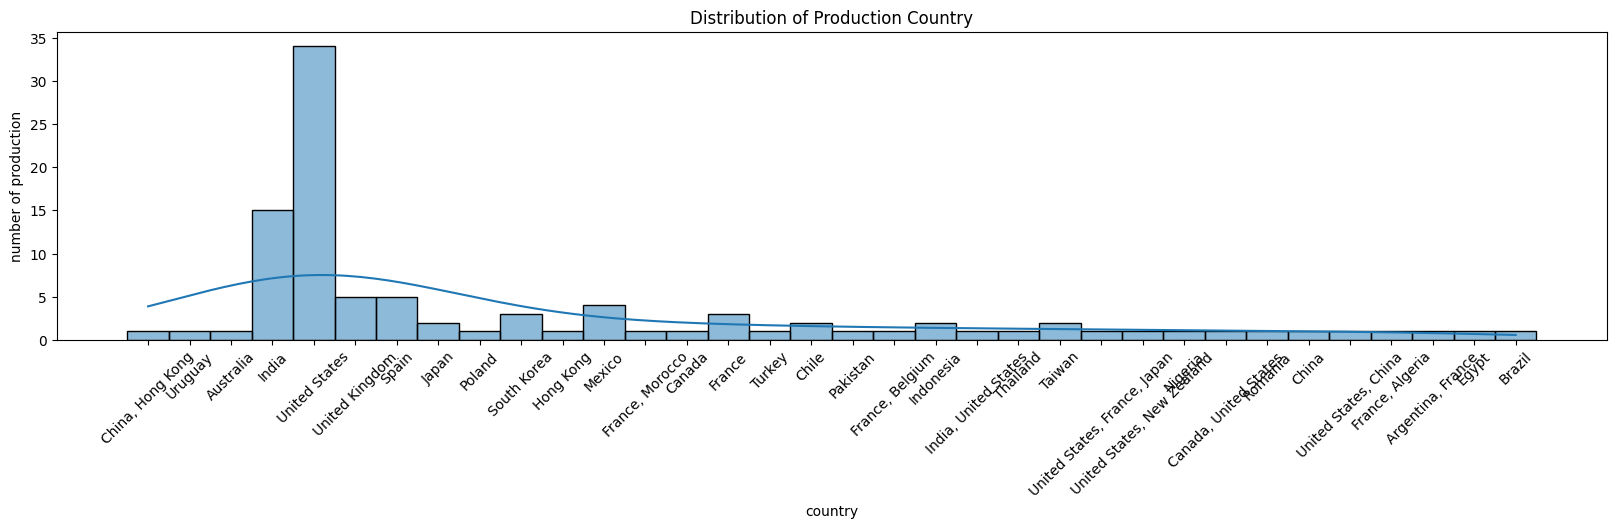

In [ ]:
fig = plt.figure(figsize=(20, 4))
ax = plt.axes()
plt.title('Distribution of Production Country')
sns.histplot(sample['Production Country'], kde=True)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
plt.xlabel('country')
plt.ylabel('number of production')

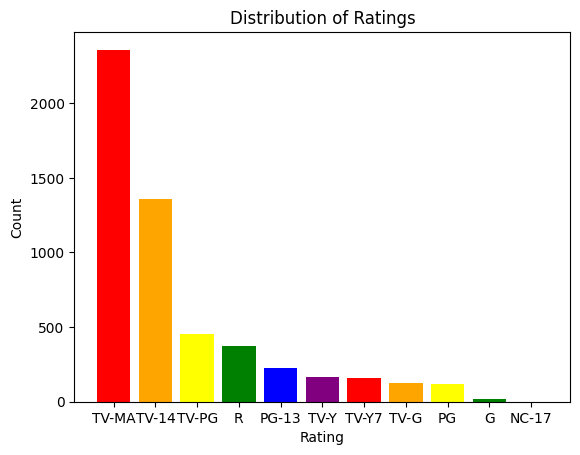

In [ ]:
# Count the occurrences of each rating
rating_counts = df['Rating'].value_counts()

# Plotting
plt.bar(rating_counts.index, rating_counts, color=['red', 'orange', 'yellow', 'green', 'blue', 'purple'])
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings')
plt.show()


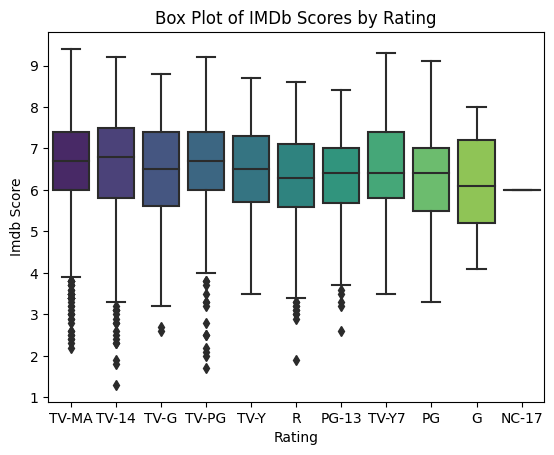

In [ ]:
import seaborn as sns

# Plotting a Box Plot
sns.boxplot(x='Rating', y='Imdb Score', data=df, palette='viridis')
plt.title('Box Plot of IMDb Scores by Rating')
plt.show()


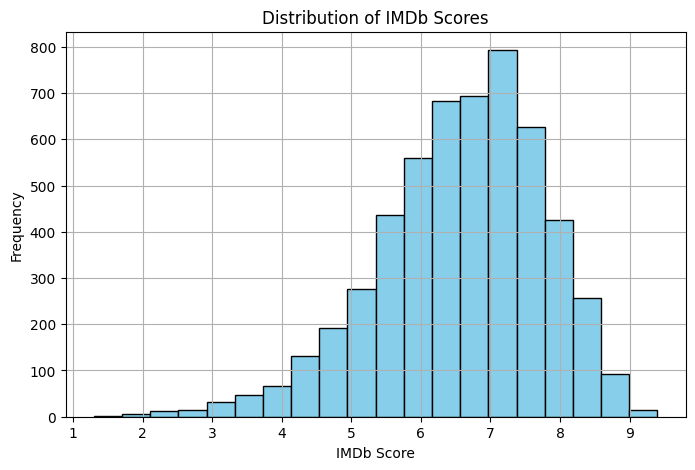

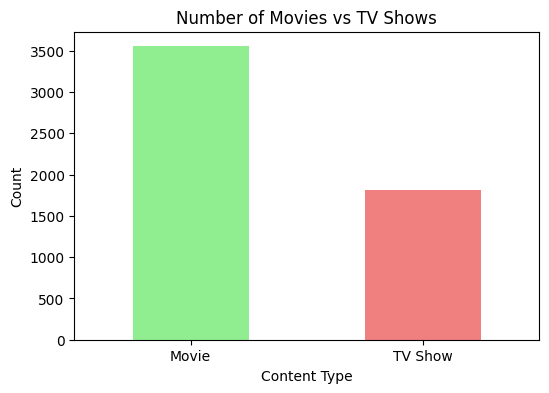

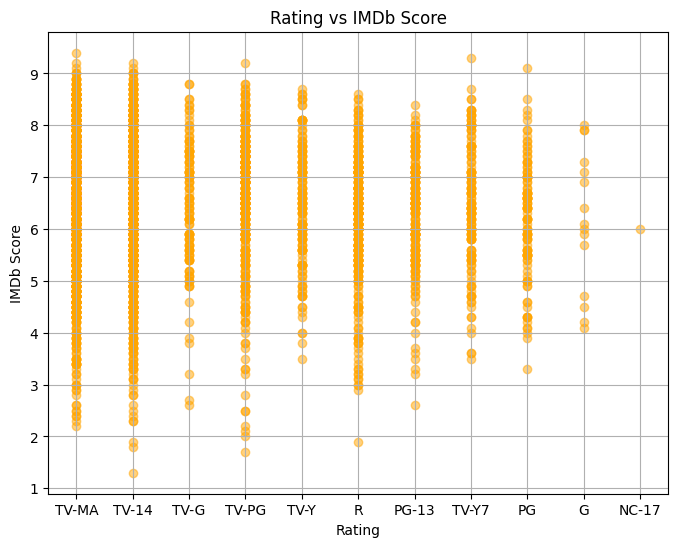

In [ ]:
# Plotting the distribution of IMDb scores
plt.figure(figsize=(8, 5))
plt.hist(df['Imdb Score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of IMDb Scores')
plt.xlabel('IMDb Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plotting a bar chart of Content Types (Movies/TV Shows)
content_type_counts = df['Content Type'].value_counts()
plt.figure(figsize=(6, 4))
content_type_counts.plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Number of Movies vs TV Shows')
plt.xlabel('Content Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Creating a scatter plot of Rating vs IMDb Score
plt.figure(figsize=(8, 6))
plt.scatter(df['Rating'], df['Imdb Score'], alpha=0.5, color='orange')
plt.title('Rating vs IMDb Score')
plt.xlabel('Rating')
plt.ylabel('IMDb Score')
plt.grid(True)
plt.show()

# **Model Traning and testing**

---



**model recommandation model ใช้ cosine similarity ในการช่วยจับคู่ข้อมูลจากเนื้อหาหรือ feature ที่เหมือนกัน**

In [ ]:
new_df = df[['Title', 'Content Type', 'Director', 'Cast', 'Rating', 'Genres', 'Description']]
new_df.set_index('Title', inplace=True)
new_df.head()

,Content Type,Director,Cast,Rating,Genres,Description
Title,,,,,,
(Un)Well,TV Show,"Raúl Campos, Jan Suter",Jeff Dunham,TV-MA,Reality TV,This docuseries takes a deep dive into the luc...
#Alive,Movie,Cho Il,"Yoo Ah-in, Park Shin-hye",TV-MA,"Horror Movies, International Movies, Thrillers","As a grisly virus rampages a city, a lone man ..."
#AnneFrank - Parallel Stories,Movie,"Sabina Fedeli, Anna Migotto","Helen Mirren, Gengher Gatti",TV-14,"Documentaries, International Movies","Through her diary, Anne Frank's story is retol..."
#blackAF,TV Show,"Raúl Campos, Jan Suter","Kenya Barris, Rashida Jones, Iman Benson, Genn...",TV-MA,TV Comedies,Kenya Barris and his family navigate relations...
#cats_the_mewvie,Movie,Michael Margolis,Jeff Dunham,TV-14,"Documentaries, International Movies",This pawesome documentary explores how our fel...


In [ ]:
new_df.fillna(' ', inplace=True)

In [ ]:
def separate(texts):
    t = []
    for text in texts.split(','):
        t.append(text.replace(' ', '').lower())
    return ' '.join(t)

def remove_space(texts):
    return texts.replace(' ', '').lower()

def remove_punc(texts):
    return texts.translate(str.maketrans('','',string.punctuation)).lower()

In [ ]:
new_df['Content Type'] = new_df['Content Type'].apply(remove_space)
new_df['Director'] = new_df['Director'].apply(separate)
new_df['Cast'] = new_df['Cast'].apply(separate)
new_df['Rating'] = new_df['Rating'].apply(remove_space)
new_df['Genres'] = new_df['Genres'].apply(separate)
new_df['Description'] = new_df['Description'].apply(remove_punc)

new_df.head()

,Content Type,Director,Cast,Rating,Genres,Description
Title,,,,,,
(Un)Well,tvshow,raúlcampos jansuter,jeffdunham,tv-ma,realitytv,this docuseries takes a deep dive into the luc...
#Alive,movie,choil,yooah-in parkshin-hye,tv-ma,horrormovies internationalmovies thrillers,as a grisly virus rampages a city a lone man s...
#AnneFrank - Parallel Stories,movie,sabinafedeli annamigotto,helenmirren genghergatti,tv-14,documentaries internationalmovies,through her diary anne franks story is retold ...
#blackAF,tvshow,raúlcampos jansuter,kenyabarris rashidajones imanbenson genneyawal...,tv-ma,tvcomedies,kenya barris and his family navigate relations...
#cats_the_mewvie,movie,michaelmargolis,jeffdunham,tv-14,documentaries internationalmovies,this pawesome documentary explores how our fel...


In [ ]:
new_df['bag_of_words'] = ''

# Combine all the words into 1 column
for i, row in enumerate(new_df.iterrows()):
    string = ''
    for col in new_df.columns:
        if row[1][col] == '':
            continue
        else:
            string += row[1][col] + ' '
            new_df['bag_of_words'][i] = string.strip()

new_df.drop(new_df.columns[:-1], axis=1, inplace=True)

In [ ]:
new_df.head()

,bag_of_words
Title,
(Un)Well,tvshow raúlcampos jansuter jeffdunham tv-ma re...
#Alive,movie choil yooah-in parkshin-hye tv-ma horror...
#AnneFrank - Parallel Stories,movie sabinafedeli annamigotto helenmirren gen...
#blackAF,tvshow raúlcampos jansuter kenyabarris rashida...
#cats_the_mewvie,movie michaelmargolis jeffdunham tv-14 documen...


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
tfid = TfidfVectorizer()
tfid_matrix = tfid.fit_transform(new_df['bag_of_words'])

#tfid_matrix.vocabulary_

In [ ]:
cosine_sim = cosine_similarity(tfid_matrix, tfid_matrix)
cosine_sim

array([[1.        , 0.00977141, 0.00944379, ..., 0.00944344, 0.01908348,
        0.04405032],
       [0.00977141, 1.        , 0.0166915 , ..., 0.01858735, 0.05206733,
        0.00997261],
       [0.00944379, 0.0166915 , 1.        , ..., 0.01214937, 0.02589675,
        0.01412589],
       ...,
       [0.00944344, 0.01858735, 0.01214937, ..., 1.        , 0.01977815,
        0.02442866],
       [0.01908348, 0.05206733, 0.02589675, ..., 0.01977815, 1.        ,
        0.00628018],
       [0.04405032, 0.00997261, 0.01412589, ..., 0.02442866, 0.00628018,
        1.        ]])

In [ ]:
# Later on we will combine with similarity as a column
final_df = df[['Title', 'Content Type']]

In [ ]:
def recommendation(Title, total_result=5, threshold=0.5):
    # Get the index
    idx = final_df[final_df['Title'] == Title].index[0]
    # Create a new column for similarity, the value is different for each title you input
    final_df['Similarity'] = cosine_sim[idx]
    sort_final_df = final_df.sort_values(by='Similarity', ascending=False)[1:total_result+1]

    # You can set a threshold if you want to norrow the result down
    #sort_final_df = sort_final_df[sort_final_df['similarity'] > threshold]

    # Is the title a movie or tv show?
    movies = sort_final_df['Title'][sort_final_df['Content Type'] == 'Movie']
    tv_shows = sort_final_df['Title'][sort_final_df['Content Type'] == 'TV Show']

    if len(movies) != 0:
        print('Similar Movie(s) list:')
        for i, movie in enumerate(movies):
            print('{}. {}'.format(i+1, movie))
        print()
    else:
        print('Similar Movie(s) list:')
        print('-\n')

    if len(tv_shows) != 0:
        print('Similar TV_show(s) list:')
        for i, tv_show in enumerate(tv_shows):
            print('{}. {}'.format(i+1, tv_show))
    else:
        print('Similar TV_show(s) list:')
        print('-')

In [ ]:
recommendation('365 Days')

Similar Movie(s) list:
1. House of the Witch
2. Stars in the Sky: A Hunting Story
3. Poacher
4. Growing Up Wild
5. Animals on the Loose: A You vs. Wild Movie

Similar TV_show(s) list:
-


## Random forest  Predict IMDB score

In [ ]:
# Drop rows with missing values
df = df.dropna()

# Split the data into features (X) and target variable (y)
X = df[['Duration_Num', 'Rating','Description','Genres']]
y = df['Imdb Score']

# Define numerical and categorical features
numerical_features = ['Duration_Num']
categorical_features = ['Rating','Description','Genres']

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse=False), categorical_features)
    ])

# Create a pipeline with preprocessor and random forest regressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Split the data into training (70%), testing (20%), and unknown (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_unknown, y_test, y_unknown = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_test = model.predict(X_test)

# Evaluate the model on the testing set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Make predictions on the unknown set
y_pred_unknown = model.predict(X_unknown)

# Evaluate the model on the unknown set
mse_unknown = mean_squared_error(y_unknown, y_pred_unknown)
r2_unknown = r2_score(y_unknown, y_pred_unknown)

print(f'Mean Squared Error (Testing Set): {mse_test}')
print(f'R-squared (Testing Set): {r2_test}')

print(f'\nMean Squared Error (Unknown Set): {mse_unknown}')
print(f'R-squared (Unknown Set): {r2_unknown}')

Mean Squared Error (Testing Set): 1.0724628740671642
R-squared (Testing Set): 0.2220420390569422

Mean Squared Error (Unknown Set): 1.1441694291044775
R-squared (Unknown Set): 0.19845149034753262


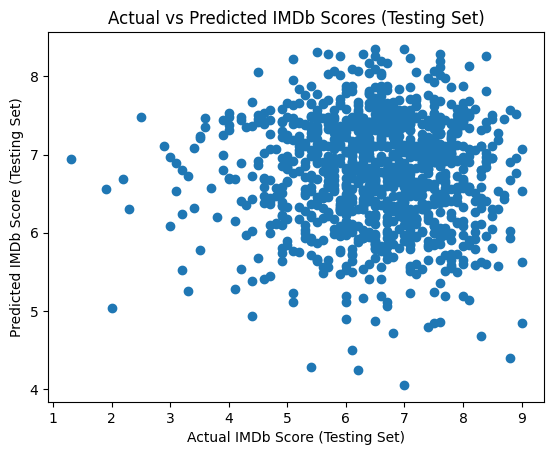

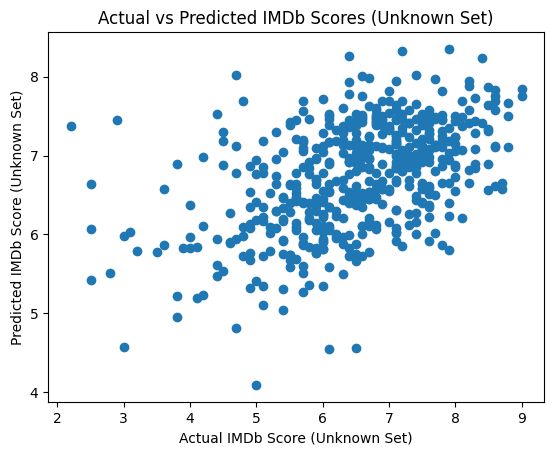

In [ ]:
import matplotlib.pyplot as plt

# Plotting the actual vs predicted IMDb scores for the testing set
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual IMDb Score (Testing Set)')
plt.ylabel('Predicted IMDb Score (Testing Set)')
plt.title('Actual vs Predicted IMDb Scores (Testing Set)')
plt.show()

# Plotting the actual vs predicted IMDb scores for the unknown set
plt.scatter(y_unknown, y_pred_unknown)
plt.xlabel('Actual IMDb Score (Unknown Set)')
plt.ylabel('Predicted IMDb Score (Unknown Set)')
plt.title('Actual vs Predicted IMDb Scores (Unknown Set)')
plt.show()


## Linear regression Predict IMDB score

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Load the dataset (assuming it contains columns for genres and IMDb scores)
data = pd.read_csv('/content/netflixData.csv')
data['Imdb Score'] = data['Imdb Score'].str.replace('/10', '').astype(float)
data = data.dropna(subset=['Imdb Score'])

# Perform one-hot encoding for genres
encoded_genres = pd.get_dummies(data['Genres'].str.get_dummies(','))

# Concatenate encoded genres with the original dataset
data = pd.concat([data, encoded_genres], axis=1)

# Define features and target
features = encoded_genres.columns.tolist()# Features are the encoded genres
target = 'Imdb Score'  # IMDb score is the target variable


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Initialize and train the regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

# R-Square
r_squared = r2_score(y_test, predictions)
print(f"R-squared: {r_squared}")

Mean Squared Error: 1.0782000958474713
R-squared: 0.2300028746968481


## Random Forest  Predict Rating

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
# Extracting 'Genres' and 'Rating' columns
data_subset = df[['Genres', 'Rating']]

# Handling missing values in the 'Rating' column
data_subset['Rating'] = data_subset['Rating'].fillna(method='ffill')  # Fill missing values with forward fill

# Encoding categorical 'Genres' column to numerical values
label_encoder = LabelEncoder()
data_subset['Genres'] = label_encoder.fit_transform(data_subset['Genres'])

# Encoding 'Rating' column to numerical values if needed
data_subset['Rating'] = label_encoder.fit_transform(data_subset['Rating'])

# Splitting into features (Genres) and target (Rating)
X = data_subset[['Genres']]
y = data_subset['Rating']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Initialize the Random Forest Regressor
model = RandomForestRegressor(n_estimators=5000, random_state=70)

# Train the model
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

# R-Square
r_squared = r2_score(y_test, predictions)
print(f"R-squared: {r_squared}")

Mean Squared Error: 2.195964731066121
R-squared: 0.24154487673879066
